This notebook documents the model fit during the first phase of Modelling Racial Caste System Project. This notebook compares the first four models. 

## Packages

In [1]:
import pandas as pd

# Text Libraries
import re
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import pickle

# Machine Learning Libraries
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier

#Model Tuning Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

#Evaluation Libraries
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from joblib import parallel_backend

#Supression
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
pd.set_option('display.max_colwidth', None)

Overview

We used a 80-20 train-test split, retaining 20% of the dataset to estimate model performance and using the remaining 80% to select a model. Several candidate models were compared using grid-search cross validation. This process suggested the use of an XGBoost model. However, we encountered issues extracting the best fit parameters from XG Boost and consequently, used Random Forest for the best parameter fit and prediction on the test data. However, the DistilBERT model performed better and was eventually chosen as the model for the project. We include notebooks for the DistilBERT selection and final model run. 

## Data Injestion

We read in the data, added weights, and checked the distribution of the training and test datasets.

In [2]:
raw = pd.read_csv("fullnjc_dataframes5.csv")
raw.drop(columns = 'Unnamed: 0', inplace=True)

In [3]:
raw["weight"] = np.where(raw.state=="VIRGINIA",2,1)

In [4]:
features = raw.loc[:,['year','sentence', 'jim_crow','state','weight']].copy()
train, test = train_test_split(raw, test_size = 0.2, random_state = 210)
X_train = train
y_train = X_train["jim_crow"]
X_test = test
y_test = X_test["jim_crow"]

In [5]:
pd.crosstab(raw.state, raw.jim_crow, normalize="index")

jim_crow,0,1
state,,
NORTH CAROLINA,0.758554,0.241446
VIRGINIA,0.907066,0.092934


In [6]:
pd.crosstab(X_train.jim_crow, X_train.state, normalize="columns")

state,NORTH CAROLINA,VIRGINIA
jim_crow,,
0,0.759224,0.905965
1,0.240776,0.094035


## Preprocessing and Analysis Setup

We performed simple preprocessing on the text:

* Removed all non-ASCII characters.
* Converted all words to lower case.
* Removed stopwords based on nltk's default list.
* we used NLTK word_tokenize to tokenize.
* ‘LengthExtractor’ computes sentence lengths, the number of words in each sentence.
* ‘ColumnTransformer’ extracts the sentence column for the length extraction and tokenization process

In [7]:
stopword = stopwords.words('english')

non_ascii_regex = r'[^\x00-\x7F]+'
def tokenize(text):     
    text = re.sub(non_ascii_regex, ' ', text)  
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    clean_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopword]
    return clean_tokens

class LengthExtractor(BaseEstimator, TransformerMixin):   
    def compute_length(self, text):
        sentence_list = word_tokenize(text)
        return len(sentence_list) 
    def fit(self, x, y=None):
        return self
    def transform(self, X):
        X_length = pd.Series(X).apply(self.compute_length)
        return pd.DataFrame(X_length)

class SelectColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    def transform(self, X, **transform_params):
        out = X[self.columns].copy()
        return out
    def fit(self, X, y=None, **fit_params):
        return self
    


The analysis is packaged into a scikit-learn Pipeline to ensure that all steps can be easily applied within cross-validation folds. Some feautres (e.g. tf-idf) could allow data from validation (or even the test set) to leak through if performed earlier.

In [8]:
pipeline = Pipeline([
        ('features', FeatureUnion([
            ('text_pipeline', Pipeline([
                ('get_text', SelectColumnsTransformer("sentence")), 
                ('vect', CountVectorizer(decode_error = "ignore", stop_words = stopword,
                      min_df = 2, max_df = 0.25)),
                ('tfidf', TfidfTransformer()),
            ])),
            ('metadata', SelectColumnsTransformer())
        ])),
        # set default estimator RandomForestClassifier 
        ('dlf', RandomForestClassifier())
])

## Cross Validation

Candidate models' performance was compared using grid search cross validation, measured using F1 scores. Parameters passed to the param_grid below change the behavior of the underlying estimators and the preprocessing defined in the Pipeline above.

In [9]:
param_grid = [
    {#####Random Forest#####
    'features__text_pipeline__vect__min_df': [5],
    'features__text_pipeline__vect__max_df': [0.25],
    'features__text_pipeline__vect__lowercase': [False],
    'features__text_pipeline__vect__ngram_range': [(1,1),(1,2),(1,3)],
    'features__text_pipeline__tfidf': [TfidfTransformer(), 'passthrough'],
    'features__metadata__columns': [[],['year']],
    'dlf' : [RandomForestClassifier()],
    'dlf__n_estimators' : [50, 100, 500],
    'dlf__max_depth' : [100, 200],
    'dlf__class_weight' : [None, "balanced"]
    },
    {#####Stochastic Gradient Descent Classifier (including SVM)#####
    'features__text_pipeline__vect__min_df': [5],
    'features__text_pipeline__vect__max_df': [0.25],
    'features__text_pipeline__vect__lowercase': [False],
    'features__text_pipeline__vect__ngram_range': [(1,1),(1,2),(1,3)],
    'features__text_pipeline__tfidf': [TfidfTransformer(), 'passthrough'],
    'features__metadata__columns': [[],['year']],
    'dlf' : [SGDClassifier()],
    'dlf__loss':  ["log"],
    'dlf__penalty': ['l2','elasticnet'],
    'dlf__learning_rate': ['optimal'],
    'dlf__early_stopping': [True,False],
    'dlf__alpha':  [0.001, 0.0001]
    },
        {#####Multinomial Naive Bayes#####
    'features__text_pipeline__vect__min_df': [5],
    'features__text_pipeline__vect__max_df': [0.25],
    'features__text_pipeline__vect__lowercase': [False],
    'features__text_pipeline__vect__ngram_range': [(1,1),(1,2),(1,3)],
    'features__text_pipeline__tfidf': [TfidfTransformer(), 'passthrough'],
    'features__metadata__columns': [[],['year']],
    'dlf' : [MultinomialNB()],
    'dlf__alpha':  [10,1,0.1,0.001,0.00001]
    },
     {#####XGBoost#####
    'features__text_pipeline__vect__min_df': [5],
    'features__text_pipeline__vect__max_df': [0.25],
    'features__text_pipeline__vect__lowercase': [False],
    'features__text_pipeline__vect__ngram_range': [(1,1),(1,2),(1,3)],
    'features__text_pipeline__tfidf': [TfidfTransformer(), 'passthrough'],
    'features__metadata__columns': [[],['year']],
    'dlf' : [XGBClassifier()],
    'dlf__learning_rate': [0.2, 0.3, 0.4],
    'dlf__max_depth': [9, 12, 15],
    'dlf__min_child_weight': [1, 3],
    'dlf__gamma': [0.5, 1, 2],
    'dlf__colsample_bytree' : [0.5, 0.6],
    'dlf__scale_pos_weight' : [1,3],
    'dlf__tree_method' : ["hist"]
    }
]

The following loop summarizes the best performance by each model considered. This search is time-intensive. At 0.9129 XG Boost was the best performing model but as explained above, the second best performing model Random Forest Classifier at 0.9024 was used for the prediction. 

In [11]:
fit_dict = dict()

for params in param_grid:
    estimator = str(params["dlf"][0]).replace("()","")
    fit_dict[estimator] = GridSearchCV(pipeline, param_grid=params, n_jobs = 32, cv=5, scoring='f1', verbose=1)
    _ = fit_dict[estimator].fit(X_train, y_train)
    print(estimator + " COMPLETE ########################")
    print("Best Score: " + str(round(fit_dict[estimator].best_score_,4)))

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:   31.2s
[Parallel(n_jobs=32)]: Done 386 tasks      | elapsed:  1.8min
[Parallel(n_jobs=32)]: Done 720 out of 720 | elapsed:  4.1min finished


RandomForestClassifier COMPLETE ########################
Best Score: 0.9024
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    6.5s
[Parallel(n_jobs=32)]: Done 386 tasks      | elapsed:   17.1s
[Parallel(n_jobs=32)]: Done 480 out of 480 | elapsed:   24.3s finished


SGDClassifier COMPLETE ########################
Best Score: 0.8549
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    5.8s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:   12.7s finished


MultinomialNB COMPLETE ########################
Best Score: 0.7933
Fitting 5 folds for each of 2592 candidates, totalling 12960 fits


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:   49.4s
[Parallel(n_jobs=32)]: Done 386 tasks      | elapsed:  2.4min
[Parallel(n_jobs=32)]: Done 736 tasks      | elapsed:  5.0min
[Parallel(n_jobs=32)]: Done 1186 tasks      | elapsed:  7.5min
[Parallel(n_jobs=32)]: Done 1736 tasks      | elapsed: 10.6min
[Parallel(n_jobs=32)]: Done 2386 tasks      | elapsed: 14.0min
[Parallel(n_jobs=32)]: Done 3136 tasks      | elapsed: 18.4min
[Parallel(n_jobs=32)]: Done 3986 tasks      | elapsed: 22.4min
[Parallel(n_jobs=32)]: Done 4936 tasks      | elapsed: 26.8min
[Parallel(n_jobs=32)]: Done 5986 tasks      | elapsed: 30.7min
[Parallel(n_jobs=32)]: Done 7136 tasks      | elapsed: 36.8min
[Parallel(n_jobs=32)]: Done 8386 tasks      | elapsed: 44.0min
[Parallel(n_jobs=32)]: Done 9736 tasks      | elapsed: 51.6min
[Parallel(n_jobs=32)]: Done 11186 tasks      | elapsed: 58.2min
[Parallel(n_jobs=32)]: Done 12736 tasks    

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...) COMPLETE ########################
Best Score: 0.9129


The code chunks below save the best parameters of the Random Forest model for use to predict on the test data. Random Forest model

In [ ]:
results_dict = dict()

# Your code to populate fit_dict
for estimator, grid_search in fit_dict.items():
    results_dict[estimator] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'cv_results': grid_search.cv_results_
    }

# Save the results_dict object to a file using pickle
with open('results_dict8.pkl', 'wb') as fileObj:
    pickle.dump(results_dict, fileObj)

In [12]:
print(fit_dict["RandomForestClassifier"].best_params_)
best_mod = pipeline
best_mod.set_params(**fit_dict["RandomForestClassifier"].best_params_)
#fit_para = best_mod.set_params(**fit_dict["RandomForestClassifier"].best_params_)

{'dlf': RandomForestClassifier(max_depth=200, n_estimators=500), 'dlf__class_weight': None, 'dlf__max_depth': 200, 'dlf__n_estimators': 500, 'features__metadata__columns': [], 'features__text_pipeline__tfidf': 'passthrough', 'features__text_pipeline__vect__lowercase': False, 'features__text_pipeline__vect__max_df': 0.25, 'features__text_pipeline__vect__min_df': 5, 'features__text_pipeline__vect__ngram_range': (1, 2)}


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text_pipeline',
                                                 Pipeline(steps=[('get_text',
                                                                  SelectColumnsTransformer(columns='sentence')),
                                                                 ('vect',
                                                                  CountVectorizer(decode_error='ignore',
                                                                                  lowercase=False,
                                                                                  max_df=0.25,
                                                                                  min_df=5,
                                                                                  ngram_range=(1,
                                                                                               2),
                                                    

## Test Set Performance

With a model selected, we use the 20% test set to measure the performance of the Random Forest model.

[Text(0.5, 1.0, 'Overall')]

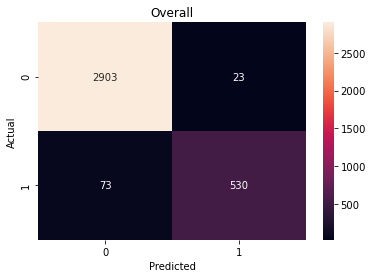

In [13]:
# Save the model and predict
best_fit = best_mod.fit(X_train,y_train)
y_pred = best_fit.predict(X_test)
y_prob = best_fit.predict_proba(X_test)

# count the number of labels
labels = np.unique(y_pred)

data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

# use sns.heatmap on top of confusion_matrix to show the confusion matrix
ax = sns.heatmap(df_cm,xticklabels=True, annot=True, fmt='.0f')
ax.set(title="Overall")

In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2926
           1       0.96      0.88      0.92       603

    accuracy                           0.97      3529
   macro avg       0.97      0.94      0.95      3529
weighted avg       0.97      0.97      0.97      3529



The fit model was 97% accurate on the test set. This provides an estimate of how accurate our model would be on new data. This is a good fit, however, as evidenced in the other scripts, the DistilBERT model outperformed the Random Forest model.

Below, we check the test data to see a few of the incorrectly classified sentences. 

In [15]:
test_df = pd.concat([X_test.reset_index(),
                     pd.Series(y_pred, name = "pred"), 
                     pd.DataFrame(y_prob, columns = ["no_prob","yes_prob"]),
                     pd.Series(y_test, name = "true_label").reset_index()], axis=1)

In [16]:
#Review incorrectly classified sentences!
test_df.loc[test_df.pred != test_df.true_label, ["year","sentence","state","pred","true_label","yes_prob"]].sample(4)

,year,sentence,state,pred,true_label,yes_prob
520,1940,"Piedmont Sanatorium, at Burkeville For maintenance and operation of the Piedmont Sanatorium, at Burkeville ~-_.----------------- $ 145,355 $ 140,345 It is provided that out of this appropriation the following salaries shall be paid: Principal executive ~----_~----------- $ 4,000 Associate physician, not exceeding... 3,000 For maintenance and operation of the Piedmont Sanatorium, at Burkeville, to be paid only out of the special revenues collected or received for the use of said Piedmont Sanatorium, and paid into the State treasury, and not out of the general fund of the State treasury.___- $ 23,735 the first year and $29,660 the second year.",VIRGINIA,0,1,0.478279
1790,1865,"The master, whether it is expressly pro-vided therein or not, shall be bound to teach the same, and shall also be bound to teach him reading, writing and common arithmetic, including the rule of three.",VIRGINIA,0,1,0.033208
1876,1916,"Be it enacted by the general assembly of Virginia, That the board of supervisors of Henry county be, and it is hereby authorized to appropriate and use a sufficient amount of the general funds raised by the general county levy as may be nec- essary to maintain the convict road force in said county for the years nineteen hundred and sixteen and nineteen hundred and seventeen, as a supplement to the county road fund.",VIRGINIA,0,1,0.043140
1782,1928,The collection of the State poll tax assessed against anyone shall not be enforced by legal process until the same has become three years past due.,VIRGINIA,0,1,0.100787


## Predict on New Data

Below, we test the performance of the model on new data, specifically, 10,000 new randomly selected sentences from the corpus

In [17]:

# Load the new CSV file into a DataFrame.
new_data = pd.read_csv('oct1_10k_samplefixed.csv') 

# Assuming you want to drop the 'jim_crow' column since it's the target variable
X_new = new_data.drop('jim_crow', axis=1)

# Fit the model on your training data (X_train, y_train)
best_fit = best_mod.fit(X_train,y_train)

# Use the trained model to make predictions on the new data
y_pred = best_fit.predict(X_new)
y_prob = best_fit.predict_proba(X_new)

# Add the predictions as a new column in the DataFrame
new_data['predjim_crow'] = y_pred
new_data['prob_non_jim_crow'] = y_prob[:, 0]  # Probability for non_jim_crow class
new_data['prob_jim_crow'] = y_prob[:, 1] # Probability for jim_crow class

# Save the DataFrame with predictions to a new CSV file
new_data.to_csv("new10k_with_predictions3.csv", index=False)


The model predicted 330 Jim Crow sentences within the 10,000 sentences. 

In [18]:
new_data.value_counts(["predjim_crow"])

predjim_crow
0               9670
1                330
dtype: int64

Below we review 50 of the sentences predicted Jim Crow and Non-Jim Crow to review them for quick insights on the prediction accuracy.

In [19]:
new_data.loc[new_data.predjim_crow != 0, ["year","sentence","predjim_crow","prob_non_jim_crow","prob_jim_crow"]].sample(50)

,year,sentence,predjim_crow,prob_non_jim_crow,prob_jim_crow
3299,1960,"It shall be unlawful for any person to obtain, seek to obtain, ex- pend, or seek to expend, any scholarship funds for any purpose other than in payment of or reimbursement for the tuition costs for the attendance of his child or ward at a nonsectarian private school in or outside the county, city, or town making such scholarship grant, or a public school located outside such county, city, or town.",1,0.227921,0.772079
7928,1893,"To restrain and punish drunkards, vagrants and street beggars: to preserve the peace and good order of the town, prevent and quel riots, disturbances and disorderly conduct and assemblages; to sup: press houses of il]-fame pnd gambling-houses; prevent and punish indecent and lewd conduct on the streets, and may require such persons to give bond, with approved security, in a penalty not ex- ceeding the sum of one hundred dollars, for their good behavior during a term of twelve months, and upon failure to give such bond may commit such persons to prison for a term not exceeding twelve months.",1,0.381871,0.618129
379,1899,"Whereas S. A. Deakins, a disabled Confederate soldier, of company I, twelfth Virginia infantry, Mahone’s brigade, was a true and gallant soldier during the late war between the states, was loyal to Virginia; and Whereas he is now suffering from the effects of an abscess, which formed while in the trenches around Richmond in eighteen hundred and sixtv-two, and has since risen seven times, almost entirely incapaci- tating him from labor; and Whereas he is now in very needy circumstances— 1.",1,0.029995,0.970005
7609,1906,"When voters registered; duties of registrars; their pay.—Nach registrar shall annually, on the third Tuesday in May, at his voting place, proceed to register the names of all qualified voters within his election district not previously registered in the said district, in accordance with the provisions of this chapter, who shall apply to be registered, com- mencing at sunrise and closing at sunset, and shall complete such regis- tration on the third Tuesday in May.",1,0.355989,0.644011
4307,1918,"See, 9, Pensioners classed as partially disabled may be re- rated.—Any old soldier now on the pension rolls, or who shall here- after be placed thereon, and classed as partially disabled, may, if such pensioner shall thereafter become totally disabled, make appli- cation to be re-rated and placed on said rolls under the class of totally disabled pensioners.",1,0.265296,0.734704
8367,1899,"Be it enacted by the general assembly of Virginia, That the county court of Albemarle shall examine into the condition of the above-named Bernard B. Harris, a Confederate soldier, and should it be found that he was true and loval to Virginia through the war, and that he is now afflicted and disabled, and incapacitated for manual Jabor, by reason of injury, disease, or old age; that he is poor and needy, and should receive aid from Virginia; and if the county court of Albemarle shall send a certificate of the fact to the auditor of public accounts in Virginia, then the auditor of public accounts is directed to place the name of Bernard B. Harris on the pension list, and pay him annually the sum of fifteen dollars on and after the first day of April, nineteen hundred.",1,0.042000,0.958000
6024,1966,Deductions shall be made on each purchase or separate farmer-to-handler transaction * in instances where the farmer is eligible to vote as set forth in § 8-609.6.,1,0.419612,0.580388
6054,1944,"m 174 > maintenance and operation of the Virginia State College for Negroes, at Petersburg ._________ a It is provided that out of this appropriation there is hereby appropriated: For the purpose of meeting the requirements o the Federal Smith-Hughes Act, a sum sufficient m 174% r maintenance of an extension division of the Virginiz State College for Negroes at Norfolk n 175 F making loans to students__-__--------------------- n 176 additiona

In [20]:
new_data.loc[new_data.predjim_crow != 1, ["year","sentence","predjim_crow","prob_non_jim_crow","prob_jim_crow"]].sample(50)

,year,sentence,predjim_crow,prob_non_jim_crow,prob_jim_crow
2402,1902,"The said lettines may be for one or more sections, and shall be for the term of one vear, ending on the first day of May of each year.",0,0.997094,0.002906
5106,1946,"(b) Upon the presentation of a petition complying with the re- quirements of this section, praying for the creation of a sanitation district, fixing the boundaries thereof and naming the counties, cities and towns which in whole or in part are to be embraced therein, the circuit court of any such county, or of any county in which any such town is situated, or the corporation court of any such city shall make an order filing said petition and fixing a day for a hearing by said court on said petition and the question of the creation of the proposed sanitation district.",0,0.987520,0.012480
9846,1869,"The said court may thereupon have summoned, from among the judges of the circuit court, 38 many as, with the judges of the supreme court of appeals not so situated, will make the number five, who shall, together, form and hold a special court of appeals, to hear and determine such case, at such time as a majority of them shall see fit; and it shall be held at Richmond, Wytheville, or Staunton, as the case may be.",0,0.987213,0.012787
3879,1968,"No recordation tax shall be charged upon such instrument, but the clerk shall be entitled to the recordation fee, and the welfare department is hereby authorized to pay such fee from its administrative fund.",0,0.999334,0.000666
7247,1952,Their terms of offices shall be for two years from the time fixed for their assuming the duties of their offices and they shall serve until their successors shall have been appointed.,0,0.998879,0.001121
5435,1922,The commission of its own motion may certify questions of law to the supreme court of appeals for decision and determination by the said court.,0,0.998842,0.001158
3076,1912,".$ Salary of the clerk of the commission, two thou- sand five hundred dollars in addition to the fees pro- vided by law ........ ccc cece ee eee eect weenie $ Assistant clerk, two thousand dollars.......... $ Statistical clerk, two thousand dollars......... $ Assessment clerk, one thousand five hundred aol Tk ; Two clerks, each one thousand two hundred ar AVS .",0,0.999277,0.000723
7312,1906,"There shall be two managers, to be chosen by the said dispensary hoard, who shall have charge of the said dispensaries, or two places for sale of liquors, subject to the control of the said dispensary board, and they shall be subject to the dismissal at the pleasure of the said dispen- sary board.",0,0.930869,0.069131
5429,1952,"The mayor of the town shall be clothed with full authority to enforce the laws and ordinances of the town, and he shall also be clothed with all powers and authority of a trial justice in civil matters within the corporate limits of the town, and in criminal matters within said limits and within one mile beyond such limits; and he shall have power to issue process hear and determine all prosecutions, cases and controversies which may arise under the by-laws and ordinances of the town.",0,0.977322,0.022678
1935,1960,"Such Municipal Judge, before entering upon the performance of his duties, shall take the oath prescribed by law and shall enter into bond in the penalty of two thousand dollars payable to the City of Colonial Heights, Virginia, and conditioned as the law directs, with corporate surety deemed sufficient by the Judge of said circuit court, which bond shall be filed with the clerk of the court and preserved in his office.",0,0.985317,0.014683
